In [1]:
# Install Libraries
!pip install --quiet --upgrade yfinance
!pip install --quiet torch-geometric
!pip install --quiet torch torchvision
!pip install --quiet optuna-integration
!pip install --quiet pytorch-ranger
!pip install --quiet torch_optimizer
!pip install --quiet transformers
!pip install --quiet bitsandbytes accelerate 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 21.9 MB/s eta 0:00:00:00:0100:01


In [2]:
# Import Essentials
import joblib
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter


warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoConfig
import torch_optimizer as optim
from torch.amp import GradScaler, autocast  # Updated import location
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            precision_recall_curve, roc_curve)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## **Functions**

In [4]:
# Calculating indicators (SMA, RSI, etc.) and generating trading signals

def calculate_sma(df, window):
    return df['Close'].rolling(window=window).mean()

def calculate_ema(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_rsi(df):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df):
    middle_bb = df['Close'].rolling(window=20).mean()
    upper_bb = middle_bb + 2 * df['Close'].rolling(window=20).std()
    lower_bb = middle_bb - 2 * df['Close'].rolling(window=20).std()
    return middle_bb, upper_bb, lower_bb

def calculate_stochastic_oscillator(df):
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    slowk = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    slowd = slowk.rolling(window=3).mean()
    return slowk, slowd

def calculate_cmf(df, window=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    cmf = mfv.rolling(window=window).sum() / df['Volume'].rolling(window=window).sum()
    return cmf

def calculate_cci(df, window=20):
    """Calculate Commodity Channel Index (CCI)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci

# Function to generate trading signals
def generate_trading_signals(df):
    df['SMA_30'] = calculate_sma(df, 30)
    df['SMA_100'] = calculate_sma(df, 100)
    df['EMA_12'] = calculate_ema(df, 12)
    df['EMA_26'] = calculate_ema(df, 26)
    df['RSI'] = calculate_rsi(df)
    df['MiddleBB'], df['UpperBB'], df['LowerBB'] = calculate_bollinger_bands(df)
    df['SlowK'], df['SlowD'] = calculate_stochastic_oscillator(df)
    df['CMF'] = calculate_cmf(df)
    df['CCI'] = calculate_cci(df)
    macd, signal = calculate_macd(df)
    df['MACD'] = macd
    df['MACD_Signal_Line'] = signal
    return df


In [5]:
# Truple Barrier

def apply_triple_barrier(close_prices, pt_pct, sl_pct, horizon):
    """
    Applies the Triple-Barrier method to classify stock trends.
    Labels:
    - 1 = Uptrend (profit target reached first)
    - -1 = Downtrend (stop loss reached first)
    - 0 = No trend (neither barrier reached within horizon)
    """
    labels = np.zeros(len(close_prices))  # Default label is 0 (no trend)
    
    for i in range(len(close_prices) - horizon):
        start_price = close_prices[i]
        future_prices = close_prices[i + 1 : i + horizon + 1]
        
        upper_barrier = start_price * (1 + pt_pct)  # Profit target
        lower_barrier = start_price * (1 - sl_pct)  # Stop loss
        
        # Check when the price first hits an upper or lower barrier
        hit_upper = np.where(future_prices >= upper_barrier)[0]
        hit_lower = np.where(future_prices <= lower_barrier)[0]

        if len(hit_upper) > 0 and (len(hit_lower) == 0 or hit_upper[0] < hit_lower[0]):
            labels[i] = 1  # Uptrend
        elif len(hit_lower) > 0:
            labels[i] = 0  # Downtrend (-1)
        else:
            labels[i] = 0  # No trend
    
    return labels


def prepare_ml_data(ticker, start_date, end_date, pt_pct=0.02, sl_pct=0.02, horizon=15):
    """
    Prepares stock data for trend classification using the Triple-Barrier method.
    
    Parameters:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date for data download.
        end_date (str): End date for data download.
        pt_pct (float): Profit target percentage (default: 2%).
        sl_pct (float): Stop loss percentage (default: 2%).
        horizon (int): Maximum holding period (default: 15 days).
    
    Returns:
        df (pd.DataFrame): DataFrame with 'Trend' column (-1 for downtrend, 0 for no trend, 1 for uptrend).
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    df = yf.download(ticker, start=start_date, end=end_date)
    
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    if 'Adj Close' in df.columns:
        df = df.drop('Adj Close', axis=1)
        

    close = torch.tensor(df['Close'].values, dtype=torch.float32).to(device)
    close = close.view(1, 1, -1)
    
    windows = torch.nn.functional.unfold(close, 
                                         kernel_size=(1, window_size), 
                                         stride=1)
    
    windows = windows.squeeze(0).transpose(0, 1)
    
    x = torch.arange(window_size, dtype=torch.float32).to(device)
    sum_x = torch.sum(x)
    sum_x_sq = torch.sum(x ** 2)
    denominator = window_size * sum_x_sq - sum_x ** 2
    
    sum_y = torch.sum(windows, dim=1)
    sum_xy = torch.sum(windows * x, dim=1)
    numerator = window_size * sum_xy - sum_x * sum_y
    slopes = numerator / denominator
    
    slopes_cpu = slopes.cpu().numpy()
    
    future_slopes = np.full(len(df), np.nan)
    future_slopes[:len(slopes_cpu)] = slopes_cpu
    df = df.assign(Future_Slope=future_slopes)
    
    mean_slope = np.nanmean(df['Future_Slope'])
    df['Future_Slope'] = df['Future_Slope'].fillna(mean_slope)
    
    # Binary Classification: 1 for Uptrend, 0 for Downtrend
    df['Up'] = (df['Future_Slope'] > 0).astype(int)




    
    
    close_prices = df['Close'].values

    
    
    df['Trend'] = apply_triple_barrier(close_prices, pt_pct, sl_pct, horizon)
    
    return df


In [6]:
# Graph Functions

def visualize_trends(df, ticker, window_size):
    """
    Creates visualizations of the stock data and binary trend classifications.
    
    Parameters:
        df (pd.DataFrame): Processed DataFrame with trend information
        ticker (str): Stock ticker symbol
        window_size (int): Window size used for slope calculation
    """
    # Create a figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), gridspec_kw={'height_ratios': [3, 1, 1]})
    
    # Plot 1: Price and trend
    ax1.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.7)
    
    # Color regions based on trend
    up_mask = df['Trend'] == 1
    down_mask = df['Trend'] == 0
    
    # Plot colored backgrounds for trend periods
    for trend, mask, color in [('Uptrend', up_mask, 'lightgreen'), 
                               ('Downtrend', down_mask, 'lightcoral')]:
        # Find consecutive periods
        if mask.any():
            trend_periods = []
            period_start = None
            
            for i, val in enumerate(mask):
                if val and period_start is None:
                    period_start = i
                elif not val and period_start is not None:
                    trend_periods.append((period_start, i-1))
                    period_start = None
            
            # Handle the case where the last period extends to the end
            if period_start is not None:
                trend_periods.append((period_start, len(mask)-1))
            
            # Shade each period
            for start, end in trend_periods:
                if start < len(df.index) and end < len(df.index):
                    ax1.axvspan(df.index[start], df.index[end], alpha=0.2, color=color)
    
    # Customize plot 1
    ax1.set_title(f'{ticker} Stock Price with Binary Trend Classification (Window: {window_size})')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Future Slope values
    ax2.plot(df.index, df['Future_Slope'], color='darkblue')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='Neutral Slope')
    ax2.set_ylabel('Slope')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Trend distribution
    trend_counts = df['Trend'].value_counts()
    colors = {1: 'purple', 0: 'lightcoral'}
    sns.barplot(x=trend_counts.index, y=trend_counts.values, palette=colors, ax=ax3)
    ax3.set_title('Distribution of Trend Classifications')
    ax3.set_ylabel('Count')
    
    # Add percentages on top of bars
    total = len(df)
    for i, count in enumerate(trend_counts):
        percentage = 100 * count / total
        ax3.text(i, count + 5, f'{percentage:.1f}%', ha='center')
    
    # Format date on x-axis
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    ax2.xaxis.set_major_formatter(date_form)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Confusion matrix-style visualization of trend transitions
    plt.figure(figsize=(6, 4))
    
    # Create transition matrix
    transitions = pd.crosstab(df['Trend'].shift(), df['Trend'], 
                             rownames=['From'], colnames=['To'],
                             normalize='index')
    
    # Rename the labels
    labels = ['Down', 'Up']
    
    # Plot heatmap
    sns.heatmap(transitions, annot=True, cmap='Purples', fmt='.1%', 
                xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Transition Probability'})
    
    plt.title('Trend Transition Probabilities')
    plt.tight_layout()
    plt.show()

## **Preprocess Data**

In [7]:
# Define parameters
ticker = "PDD"
start_date = "2022-01-01"
end_date = "2026-01-01"
window_size = 15

# Example usage
df = prepare_ml_data(ticker, start_date, end_date, horizon=window_size)

Using device: cuda
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [8]:
#visualize_trends(df.tail(90), ticker, window_size)

In [9]:
# Generate indicators
data = generate_trading_signals(df)

# Display the shape of the data
print("Data Shape:")
print(data.shape)


# Check for missing values
missing_columns = data.columns[data.isnull().any()]
if missing_columns.size > 0:
    missing_values = data[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")

Data Shape:
(813, 22)

Missing Data:
          Total    Percent
Price                     
SMA_100      99  12.177122
CCI          38   4.674047
SMA_30       29   3.567036
MiddleBB     19   2.337023
LowerBB      19   2.337023
UpperBB      19   2.337023
CMF          19   2.337023
SlowD        15   1.845018
RSI          13   1.599016
SlowK        13   1.599016


In [10]:
data = data.dropna()

## **Deep Learning**

In [11]:
features = [
    'EMA_12', 'EMA_26', 'RSI', 'Close',
    'MiddleBB', 'UpperBB', 'LowerBB', 'SlowK', 'SlowD',
    'CMF', 'CCI', 'MACD', 'MACD_Signal_Line','Volume','Future_Slope'
]

In [12]:
# Complex Version
def prepare_financial_data_v2(df, features, lookback=60, train_split=0.8, pt_pct=0.03, sl_pct=0.02, horizon=15):
    """
    Prepare data for trend prediction using Triple-Barrier Method with labels based on profit target and stop-loss.

    Parameters:
    - df: DataFrame with stock data (e.g., 'Close', 'Open', etc.).
    - features: List of feature columns to use for prediction.
    - lookback: Number of previous days to use as features (default: 60).
    - train_split: Fraction of data to use for training (default: 0.8).
    - pt_pct: Profit target percentage for labeling (default: 3%).
    - sl_pct: Stop-loss percentage for labeling (default: 2%).
    - horizon: Number of days to consider for the barriers (default: 15).

    Returns:
    - train_loader: PyTorch DataLoader for training.
    - test_loader: PyTorch DataLoader for testing.
    """

    # Normalize the features
    df_normalized = df.copy()
    for feature in features:
        if feature in df.columns:
            train_size = int(len(df) * train_split)
            train_data = df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                df_normalized[feature] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                df_normalized[feature] = (df[feature] - min_val) / (max_val - min_val + 1e-8)
    
    df_normalized = df_normalized.ffill().bfill().fillna(0)
    
    X, y_labels = [], []
    
    for i in range(lookback, len(df_normalized) - horizon):
        X.append(df_normalized[features].iloc[i-lookback:i].values)

        if 'Close' in df.columns:
            # Calculate the price change thresholds
            entry_price = df['Close'].iloc[i]  # Price at the start of the window
            target_price = entry_price * (1 + pt_pct)  # Profit target (e.g., +3%)
            stop_loss_price = entry_price * (1 - sl_pct)  # Stop loss (e.g., -2%)
            
            # Look for profit target or stop-loss within the horizon
            future_prices = df['Close'].iloc[i:i + horizon + 1]
            hit_target = (future_prices >= target_price).any()
            hit_stop_loss = (future_prices <= stop_loss_price).any()

            # Assign the label based on the barrier hit
            if hit_target:
                y_labels.append(1)  # Uptrend
            elif hit_stop_loss:
                y_labels.append(0)  # Downtrend
            else:
                y_labels.append(0)  # No clear trend (downtrend)

    # Convert to numpy arrays
    X = np.array(X)
    y_labels = np.array(y_labels)
    
    # Split data into train and test sets
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y_labels[:train_size], y_labels[train_size:]
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    
    return train_loader, test_loader


In [13]:
# Simple Version
def prepare_financial_data(df, features, lookback=60, train_split=0.8):
    """Prepare data for 15-day trend prediction"""
    df_normalized = df.copy()
    for feature in features:
        if feature in df.columns:
            train_size = int(len(df) * train_split)
            train_data = df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                df_normalized[feature] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                df_normalized[feature] = (df[feature] - min_val) / (max_val - min_val + 1e-8)
    
    df_normalized = df_normalized.ffill().bfill().fillna(0)
    
    X, y_15day = [], []
    for i in range(lookback, len(df_normalized) - 15):
        X.append(df_normalized[features].iloc[i-lookback:i].values)
        if 'Close' in df.columns:
            price_change = df['Close'].iloc[i+14] > df['Close'].iloc[i-1]
            y_15day.append(float(price_change))
    
    X = np.array(X)
    y_15day = np.array(y_15day)
    
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y_15day[:train_size], y_15day[train_size:]
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=32, 
        shuffle=True, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        pin_memory=True,
        num_workers=4,
        persistent_workers=True
    )
    
    return train_loader, test_loader

In [14]:


class FinancialTransformer(nn.Module):
    def __init__(self, feature_dim, embed_dim=768, num_heads=12, num_layers=8, 
                 dropout_rate=0.1, max_seq_len=60, pretrained_model_name="bert-base-uncased", 
                 pooling="attention"):
        super(FinancialTransformer, self).__init__()
        
        if embed_dim % num_heads != 0:
            embed_dim = (embed_dim // num_heads) * num_heads
        
        self.tech_embedding = nn.Sequential(
            nn.Linear(feature_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )
        
        self.register_buffer('pos_encoding', torch.zeros(1, max_seq_len, embed_dim))
        nn.init.trunc_normal_(self.pos_encoding, std=0.02)
        
        config = AutoConfig.from_pretrained(pretrained_model_name)
        config.hidden_size = embed_dim
        config.num_attention_heads = num_heads
        config.num_hidden_layers = num_layers
        config.hidden_dropout_prob = dropout_rate
        config.attention_probs_dropout_prob = dropout_rate
        self.transformer = AutoModel.from_config(config)
        
        assert pooling in ["mean", "max", "attention"]
        self.pooling = pooling
        
        if pooling == "attention":
            self.attention_pool = nn.Sequential(
                nn.Linear(embed_dim, embed_dim//2),
                nn.Mish(),
                nn.Linear(embed_dim//2, 1),
                nn.Softmax(dim=1)
            )
        
        self.output_15day = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.GELU(),
            nn.LayerNorm(embed_dim//2),
            nn.Linear(embed_dim//2, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for name, module in self.named_children():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
        nn.init.zeros_(self.pos_encoding)
    
    def forward(self, x):
        tech_embedded = self.tech_embedding(x)
        tech_embedded = tech_embedded + self.pos_encoding[:, :x.size(1)]
        
        transformer_output = self.transformer(
            inputs_embeds=tech_embedded
        ).last_hidden_state
        
        if self.pooling == "mean":
            pooled_output = transformer_output.mean(dim=1)
        elif self.pooling == "max":
            pooled_output = transformer_output.max(dim=1).values
        elif self.pooling == "attention":
            attention_weights = self.attention_pool(transformer_output)
            pooled_output = (attention_weights * transformer_output).sum(dim=1)
        
        pred_15day = self.output_15day(pooled_output).squeeze(1)
        return {'15day': pred_15day}





def predict_15day_trend(model, recent_data, features, lookback=60):
    """Ensure prediction also handles device properly"""
    device = next(model.parameters()).device
    input_seq = recent_data[features].tail(lookback).values
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad(), autocast(device_type='cuda'):
        output = model(input_tensor)['15day']
        prob = torch.sigmoid(output).item()
    
    return {
        'prediction': 'UP' if prob > 0.5 else 'DOWN',
        'confidence': max(prob, 1-prob),
        'probability': prob
    }

def plot_results(metrics, probs, targets):
    """Visualize evaluation results"""
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    
    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (AUC = {metrics["roc_auc"]:.2f})')
    
    # Metrics Summary
    plt.subplot(1, 3, 3)
    plt.text(0.1, 0.8, f"Accuracy: {metrics['accuracy']:.2f}")
    plt.text(0.1, 0.6, f"Precision: {metrics['precision']:.2f}")
    plt.text(0.1, 0.4, f"Recall: {metrics['recall']:.2f}")
    plt.text(0.1, 0.2, f"F1 Score: {metrics['f1']:.2f}")
    plt.axis('off')
    plt.title('Performance Metrics')
    
    plt.tight_layout()
    plt.show()



In [15]:
# Train, Evaluate & Predict Functions

def train_model(model, train_loader, val_loader, epochs=10000, lr=5e-5, 
               weight_decay=1e-4, patience=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Force CUDA context creation and optimization settings
    if device.type == 'cuda':
        torch.zeros(1).to(device)  # Create context
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
    
    model = model.to(device)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    
    # Corrected GradScaler initialization
    scaler = GradScaler(enabled=True)
    
    optimizer = optim.Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=20, eta_min=1e-6)
    criterion = nn.BCEWithLogitsLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            x = batch[0].to(device, non_blocking=True)
            y_15day = batch[1].to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            # Corrected autocast usage
            with autocast(device_type='cuda'):
                outputs = model(x)
                loss = criterion(outputs['15day'], y_15day)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device, non_blocking=True)
                y_15day = batch[1].to(device, non_blocking=True)
                
                outputs = model(x)
                loss = criterion(outputs['15day'], y_15day)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        scheduler.step()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {
                'model_state_dict': model.module.state_dict() if hasattr(model, 'module') else model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'best_val_loss': best_val_loss
            }
            torch.save(best_model_state, 'best_financial_transformer.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Load best model securely
    checkpoint = torch.load('best_financial_transformer.pt', 
                          map_location=device,
                          weights_only=True)
    if hasattr(model, 'module'):
        model.module.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint['model_state_dict'])
    
    return model.to(device)

def evaluate_model(model, data_loader, device=None):
    """Comprehensive model evaluation"""
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_preds, all_probs, all_targets = [], [], []
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device, non_blocking=True)
            y = batch[1].to(device, non_blocking=True)
            
            with autocast(device_type='cuda'):
                outputs = model(x)
                probs = torch.sigmoid(outputs['15day']).cpu().numpy()
            
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_targets.extend(y.cpu().numpy())
    
    metrics = {
        'accuracy': accuracy_score(all_targets, all_preds),
        'precision': precision_score(all_targets, all_preds),
        'recall': recall_score(all_targets, all_preds),
        'f1': f1_score(all_targets, all_preds),
        'roc_auc': roc_auc_score(all_targets, all_probs),
        'confusion_matrix': confusion_matrix(all_targets, all_preds),
    }
    
    return metrics, all_probs, all_targets

def predict_future_transformer(data_df, model, features, lookback=60, horizon=15):
    """
    Predict future market trend using transformer model
    
    Args:
        data_df: DataFrame with feature data
        model: Trained FinancialTransformer model
        features: List of feature names to use
        lookback: Number of days to look back (should match model's expected sequence length)
        horizon: Prediction horizon (15 days in our case)
        
    Returns:
        Boolean indicating uptrend (True) or downtrend (False)
        Dictionary containing full prediction details
    """
    device = next(model.parameters()).device
    
    # Get the last lookback days of data
    recent_data = data_df[features].tail(lookback).values
    
    # Normalize the data - applying the same normalization logic as in prepare_financial_data
    normalized_data = recent_data.copy()
    for i, feature in enumerate(features):
        if feature in data_df.columns:
            # Use the same normalization as prepare_financial_data
            train_size = int(len(data_df) * 0.8)  # Same 80% train split as prepare_financial_data
            train_data = data_df[feature].iloc[:train_size]
            
            if train_data.max() == train_data.min():
                normalized_data[:, i] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                normalized_data[:, i] = (recent_data[:, i] - min_val) / (max_val - min_val + 1e-8)
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.FloatTensor(normalized_data).unsqueeze(0).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad(), autocast(device_type='cuda'):
        output = model(input_tensor)['15day']
        prob = torch.sigmoid(output).item()
    
    # Create prediction dictionary
    prediction = {
        'prediction': 'UP' if prob > 0.5 else 'DOWN',
        'probability': prob,
        'confidence': max(prob, 1 - prob)
    }
    
    print(f"Market trend prediction for {horizon} days ahead: {prediction['prediction']}")
    print(f"Probability: {prediction['probability']:.4f}")
    print(f"Confidence: {prediction['confidence']:.4f}")
    
    # Return both boolean and full prediction details
    return prediction['prediction'] == 'UP', prediction

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using device: cuda


/usr/local/lib/python3.10/dist-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1642.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch 1/10000 - Train Loss: 0.7164, Val Loss: 0.6188
Epoch 2/10000 - Train Loss: 0.6164, Val Loss: 0.6405
Epoch 3/10000 - Train Loss: 0.5934, Val Loss: 0.5850
Epoch 4/10000 - Train Loss: 0.5968, Val Loss: 0.5863
Epoch 5/10000 - Train Loss: 0.5766, Val Loss: 0.5806
Epoch 6/10000 - Train Loss: 0.5850, Val Loss: 0.6300
Epoch 7/10000 - Train Loss: 0.5727, Val Loss: 0.5747
Epoch 8/10000 - Train Loss: 0.5839, Val Loss: 0.5790
Epoch 9/10000 - Train Loss: 0.5780, Val Loss: 0.5789
Epoch 10/10000 - Train Loss: 0.5769, Val Loss: 0.5835
Epoch 11/10000 - Train Loss: 0.5665, Val Loss: 0.5836
Epoch 12/10000 - Train Loss: 0.5589, Val Loss: 0.6022
Epoch 13/10000 - Train Loss: 0.5684, Val Loss: 0.5789
Epoch 14/10000 - Train Loss: 0.5617, Val Loss: 0.5804
Epoch 15/10000 - Train Loss: 0.5526, Val Loss: 0.5804
Epoch 16/10000 - Train Loss: 0.5550, Val Loss: 0.5771
Epoch 17/10000 - Train Loss: 0.5502, Val Loss: 0.5745
Epoch 18/10000 - Train Loss: 0.5512, Val Loss: 0.5919
Epoch 19/10000 - Train Loss: 0.5503, 

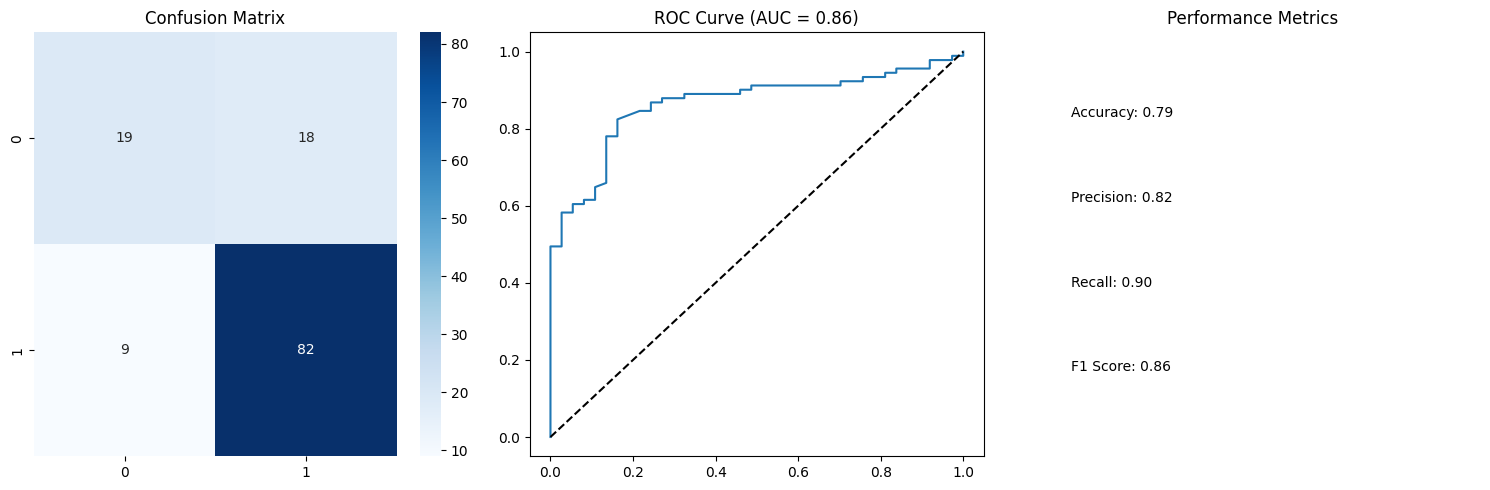


Validation Metrics:
accuracy: 0.7891
precision: 0.8200
recall: 0.9011
f1: 0.8586
roc_auc: 0.8647


In [16]:
# Example usage
if __name__ == "__main__":

    # 1. Prepare data
    df = data
    train_loader, val_loader = prepare_financial_data_v2(df, features)
    
    # 2. Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FinancialTransformer(feature_dim=len(features)).to(device)
    


    # 3. Train model (assuming you have a training function)
    model = train_model(model, train_loader, val_loader)


    # 4. Evaluate
    model.eval
    print("Evaluating on validation set...")
    val_metrics, val_probs, val_targets = evaluate_model(model, val_loader)
    plot_results(val_metrics, val_probs, val_targets)
    
    print("\nValidation Metrics:")
    for k, v in val_metrics.items():
        if k != 'confusion_matrix':
            print(f"{k}: {v:.4f}")

In [17]:
# Prediction
if __name__ == "__main__":
    model.eval()  # ✅ Set model to evaluation mode before inference
    future_prediction, pred_details = predict_future_transformer(
        data_df=data,
        model=model,
        features=features,
        lookback=60,  # Should match what you used in prepare_financial_data
        horizon=15
    )
    
    print(f"Prediction for next {15} trading days: {'Uptrend' if future_prediction else 'Downtrend'}")
    print("Full prediction details:", pred_details)

Market trend prediction for 15 days ahead: DOWN
Probability: 0.4785
Confidence: 0.5215
Prediction for next 15 trading days: Downtrend
Full prediction details: {'prediction': 'DOWN', 'probability': 0.478515625, 'confidence': 0.521484375}


In [18]:
# Save the model's state_dict
torch.save(model.state_dict(), 'financial_transformer_weights.pth')

# If using DataParallel (multi-GPU), save model.module.state_dict()
if isinstance(model, nn.DataParallel):
    torch.save(model.module.state_dict(), 'financial_transformer_weights.pth')
else:
    torch.save(model.state_dict(), 'financial_transformer_weights.pth')

In [28]:
# Save the model's state_dict
torch.save(model.state_dict(), 'financial_transformer_weights.pth')

# Save the entire model
torch.save(model, 'financial_transformer_full.pth')

### **Prepare the New Data**

In [53]:
# Define parameters
ticker = "GOOGL"
start_date = "2022-01-01"
end_date = "2026-01-01"
window_size = 15

# Generate indicators and trading signals
df = prepare_ml_data(ticker, start_date, end_date, horizon=window_size)  # Generate indicators
data = generate_trading_signals(df)
data = data.dropna()  # Remove rows with missing values

[*********************100%***********************]  1 of 1 completed

Using device: cuda



#### ✅ **Option 1: Load Only Weights (Safer)**
If your saved file contains only weights, use `weights_only=True`:  
```python
model = FinancialTransformer(feature_dim=len(features)).to(device)  # Reinitialize model
model.load_state_dict(torch.load("financial_transformer_full.pth", map_location=device, weights_only=True))
model.train()  # Ensure it's in training mode
```
🚀 **Why?**  
This prevents loading unknown Python objects from the file, reducing security risks.

---

#### ✅ **Option 2: Explicitly Allowlist Your Model Class**
If you **must** load the entire model (architecture + weights), then you need to explicitly allowlist your model class:
```python
import torch.serialization
torch.serialization.add_safe_globals([FinancialTransformer])  # Allowlist your model class
model = torch.load("financial_transformer_full.pth", map_location=device)
model.to(device)
model.train()
```

<ipython-input-54-d9cbaf0b4e44>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("financial_transformer_full.pth", map_location=device)


Using device: cuda
Epoch 1/10000 - Train Loss: 0.9509, Val Loss: 0.8311
Epoch 2/10000 - Train Loss: 0.7205, Val Loss: 0.9002
Epoch 3/10000 - Train Loss: 0.5952, Val Loss: 0.9737
Epoch 4/10000 - Train Loss: 0.5591, Val Loss: 0.9188
Epoch 5/10000 - Train Loss: 0.5470, Val Loss: 0.9109
Epoch 6/10000 - Train Loss: 0.5310, Val Loss: 0.8667
Epoch 7/10000 - Train Loss: 0.5096, Val Loss: 0.8887
Epoch 8/10000 - Train Loss: 0.4811, Val Loss: 0.8647
Epoch 9/10000 - Train Loss: 0.4987, Val Loss: 0.8379
Epoch 10/10000 - Train Loss: 0.4763, Val Loss: 0.8608
Epoch 11/10000 - Train Loss: 0.4611, Val Loss: 0.8355
Epoch 12/10000 - Train Loss: 0.4545, Val Loss: 0.8337
Epoch 13/10000 - Train Loss: 0.4413, Val Loss: 0.8437
Epoch 14/10000 - Train Loss: 0.4352, Val Loss: 0.8287
Epoch 15/10000 - Train Loss: 0.4233, Val Loss: 0.7977
Epoch 16/10000 - Train Loss: 0.4143, Val Loss: 0.7947
Epoch 17/10000 - Train Loss: 0.4204, Val Loss: 0.8008
Epoch 18/10000 - Train Loss: 0.4144, Val Loss: 0.8033
Epoch 19/10000 - T

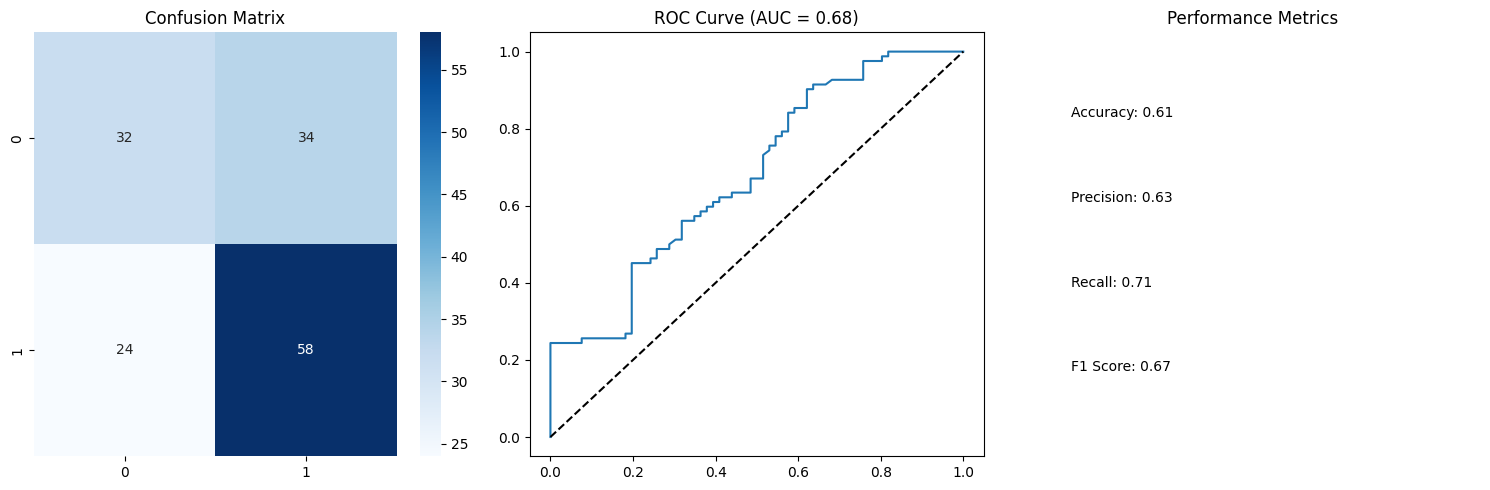


Validation Metrics:
accuracy: 0.6081
precision: 0.6304
recall: 0.7073
f1: 0.6667
roc_auc: 0.6801


In [54]:
# Example usage
if __name__ == "__main__":

    # 1. Prepare data
    train_loader, val_loader = prepare_financial_data_v2(df, features)
    

    # 2. Load pre-trained weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load("financial_transformer_full.pth", map_location=device)
    
    # 3. Initialize model
    model.to(device)  # Move to GPU/CPU
    model.train()  # Ensure it's in training mode


    # 4. Train model (assuming you have a training function)
    model = train_model(model, train_loader, val_loader)


    # 5. Evaluate
    print("Evaluating on validation set...")
    val_metrics, val_probs, val_targets = evaluate_model(model, val_loader)
    plot_results(val_metrics, val_probs, val_targets)
    
    print("\nValidation Metrics:")
    for k, v in val_metrics.items():
        if k != 'confusion_matrix':
            print(f"{k}: {v:.4f}")

In [55]:
# Prediction
if __name__ == "__main__":
    model.eval()  # ✅ Set model to evaluation mode before inference

    future_prediction, pred_details = predict_future_transformer(
        data_df=data,
        model=model,
        features=features,
        lookback=60,  # Should match what you used in prepare_financial_data
        horizon=15
    )
    
    print(f"Prediction for next {15} trading days: {'Uptrend' if future_prediction else 'Downtrend'}")
    print("Full prediction details:", pred_details)


Market trend prediction for 15 days ahead: UP
Probability: 0.9175
Confidence: 0.9175
Prediction for next 15 trading days: Uptrend
Full prediction details: {'prediction': 'UP', 'probability': 0.91748046875, 'confidence': 0.91748046875}


In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), 'financial_transformer_weights.pth')

# Save the entire model
torch.save(model, 'financial_transformer_full.pth')